In [66]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests
import pandas as pd
import os
import tqdm
import glob
import multiprocessing as mp
import numpy as np
from sklearn.model_selection import train_test_split


In [26]:
image = 'D:\\W\\VS\\VS Folder\\DFD\\DFDC MTCNN Extracted\\aagfhgtpmv\\0.png'
image = Image.open(image)
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state


torch.Size([1, 197, 768])


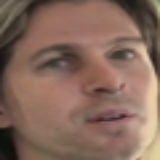

tensor([[ 2.7074e-04,  7.0599e-02, -2.8312e-01, -8.4995e-02,  1.9900e-02,
          6.4487e-02, -3.6190e-02,  2.2865e-01, -5.0423e-02, -1.0378e-01,
          3.1107e-02, -2.0352e-01,  1.7166e-01,  5.9303e-02, -3.8801e-01,
          1.2383e-01, -2.6910e-02, -1.0341e-01, -2.7075e-01,  3.3392e-04,
         -1.3116e-03, -2.5203e-01, -3.7753e-02,  7.5436e-02, -1.9325e-01,
          9.1367e-03,  2.0550e-01, -2.7846e-01, -4.4962e-01,  7.0547e-02,
          6.2702e-02, -1.6769e-01,  6.7661e-02,  6.1925e-03, -7.2673e-02,
          2.5908e-01,  2.8533e-02, -4.4681e-02, -1.5391e-01, -1.9749e-02,
         -1.9470e-01,  1.5213e-01,  4.7206e-02, -5.7197e-02,  3.8186e-02,
         -8.6909e-02, -1.0453e-01,  2.0388e-02, -6.2598e-02, -1.8467e-01,
          3.8786e-02,  9.3850e-02, -1.2636e-01, -7.7600e-02,  1.2262e-01,
         -9.2011e-02,  5.3035e-02, -5.1733e-03,  1.5790e-01, -3.0962e-02,
         -1.8768e-01, -1.6234e-01, -7.4247e-02,  1.2009e-02,  4.4539e-02,
          3.4902e-02,  5.0441e-02,  1.

In [41]:
print(last_hidden_states.shape)  # (batch_size, sequence_length, hidden_size)
cls_feature_vector = last_hidden_states[:, 0, :]
display(image)
display(cls_feature_vector)

# Training Data

In [58]:
N_FACES = 5
TEST_SIZE = 0.3
RANDOM_STATE = 123

BATCH_SIZE = 32
NUM_WORKERS = mp.cpu_count()

WARM_UP_EPOCHS = 10
WARM_UP_LR = 1e-4
FINE_TUNE_EPOCHS = 100
FINE_TUNE_LR = 1e-6

THRESHOLD = 0.5
EPSILON = 1e-7

In [ ]:
train_dir = 'D:\\W\\VS\\VS Folder\\DFD\\DFDC MTCNN Extracted\\'
train_df = pd.read_csv(os.path.join(train_dir, 'metadata.csv'))
train_df['path'] = train_df['filename'].apply(lambda x: os.path.join(train_dir, x.split('.')[0]))

# Remove empty folders
train_df = train_df[train_df['path'].map(lambda x: os.path.exists(x))]
train_df

,filename,label,split,original,path
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aag...
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aap...
2,abarnvbtwb.mp4,REAL,train,NaN,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aba...
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\abo...
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\abq...
...,...,...,...,...,...
395,etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\ete...
396,etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\etm...
397,etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\eto...
398,eudeqjhdfd.mp4,REAL,train,NaN,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\eud...


In [61]:
valid_train_df = pd.DataFrame(columns=['filename', 'label', 'split', 'original', 'path'])

# for row_idx, row in tqdm(train_df.iterrows()):
for row_idx in tqdm.tqdm(train_df.index):
    row = train_df.loc[row_idx]
    img_dir = row['path']
    face_paths = glob.glob(f'{img_dir}/*.png')

    if len(face_paths) >= N_FACES: # Satisfy the minimum requirement for the number of faces
        face_indices = [
            path.split('\\')[-1].split('.')[0].split('_')[0]
            for path in face_paths
        ]
        max_idx = np.max(np.array(face_indices, dtype=np.uint32))

        selected_paths = []

        for i in range(N_FACES):
            stride = int((max_idx + 1)/(N_FACES**2))
            sample = np.linspace(i*stride, max_idx + i*stride, N_FACES).astype(int)

            # Get faces
            for idx in sample:
                paths = glob.glob(f'{img_dir}/{idx}*.png')

                selected_paths.extend(paths)
                if len(selected_paths) >= N_FACES: # Get enough faces
                    break

            if len(selected_paths) >= N_FACES:  # Get enough faces
                valid_train_df = pd.concat([valid_train_df, pd.DataFrame([row])], ignore_index=True)
                break

100%|██████████| 400/400 [00:01<00:00, 309.01it/s]


In [67]:
valid_train_df['label']=valid_train_df['label'].replace({'FAKE': 1, 'REAL': 0})
display(valid_train_df.head())

label_count = valid_train_df.groupby('label').count()['filename']
print(label_count)

X = valid_train_df['path'].to_numpy()
y = valid_train_df['label'].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

,filename,label,split,original,path
0,aagfhgtpmv.mp4,1,train,vudstovrck.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aag...
1,aapnvogymq.mp4,1,train,jdubbvfswz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aap...
2,abarnvbtwb.mp4,0,train,NaN,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aba...
3,abqwwspghj.mp4,1,train,qzimuostzz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\abq...
4,acifjvzvpm.mp4,1,train,kbvibjhfzo.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aci...


label
0     76
1    306
Name: filename, dtype: int64


# Training

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.eval()  # Set model to evaluation mode

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [ ]:
batch_size = 16
features = []
image_paths = train_df['path']
for path in image_paths:
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        images = [Image.open(p).convert("RGB") for p in batch_paths]
        inputs = processor(images=images, return_tensors="pt")
        
        with torch.no_grad():
            outputs = model(**inputs)
            # CLS token is at position 0 for each image in the batch
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # Shape: (batch, hidden_dim)
            features.append(cls_embeddings.cpu())
        
# Concatenate all features into a single tensor
features = torch.cat(features, dim=0)  # Shape: (num_images, hidden_dim)

NameError: name 'image_paths' is not defined